In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import scipy.io as sio
from os import listdir
from os.path import isfile, join
import time
import copy

## Load in Dataset

In [2]:
!git clone https://github.com/mzhao98/emotion_recognition

Cloning into 'emotion_recognition'...
remote: Enumerating objects: 34098, done.
remote: Total 34098 (delta 0), reused 0 (delta 0), pack-reused 34098
Receiving objects: 100% (34098/34098), 141.96 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (35909/35909), done.


In [3]:
def load_dataset():
    train_dir = 'emotion_recognition/data/train/'
    test_dir = 'emotion_recognition/data/test/'
    categories = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
    positive = ['happy', 'surprise']
    neither = [ 'neutral']
    negative = ['sad', 'fear', 'angry', 'disgust']

    train_file_dictionary = {}
    train_imagefile_to_class_dictionary = {}
    for emotion in categories:
        train_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(categories)):
        for subdir, dirs, files in os.walk(train_dir+categories[i]+'/'):
            for file in files:
                train_file_dictionary[categories[i]].append(train_dir+categories[i]+'/'+file)
                train_imagefile_to_class_dictionary[counter] = {}
                train_imagefile_to_class_dictionary[counter]['file'] = train_dir+categories[i]+'/'+file
                if categories[i] in positive:
                  train_imagefile_to_class_dictionary[counter]['label'] = 0
                elif categories[i] in neither:
                  train_imagefile_to_class_dictionary[counter]['label'] = 1
                elif categories[i] in negative:
                  train_imagefile_to_class_dictionary[counter]['label'] = 2
                counter += 1



    test_file_dictionary = {}
    test_imagefile_to_class_dictionary = {}
    for emotion in categories:
        test_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(categories)):
        for subdir, dirs, files in os.walk(test_dir+categories[i]+'/'):
            for file in files:
                test_file_dictionary[categories[i]].append(test_dir+categories[i]+'/'+file)
                test_imagefile_to_class_dictionary[counter] = {}
                test_imagefile_to_class_dictionary[counter]['file'] = test_dir+categories[i]+'/'+file
                if categories[i] in positive:
                  test_imagefile_to_class_dictionary[counter]['label'] = 0
                elif categories[i] in neither:
                  test_imagefile_to_class_dictionary[counter]['label'] = 1
                elif categories[i] in negative:
                  test_imagefile_to_class_dictionary[counter]['label'] = 2
                counter += 1

    return train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary

## Create Image Dataset

In [4]:
class FacialEmotionDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, imagefile_to_class_dictionary, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            imagefile_to_class_dictionary (dictionary): Dictionary of image filenames to class for each emotion.
        """
#         self.root_dir = root_dir
        self.imagefile_to_class_dictionary = imagefile_to_class_dictionary
        self.transform = transforms.Compose(
                [
                    transforms.Resize((96, 96)),
                    transforms.ToTensor(),
                    # transforms.CenterCrop(10),
                 
                 transforms.Normalize((0.5), 
                                      (0.5))])


    def __len__(self):
        return len(self.imagefile_to_class_dictionary.keys())

    def __getitem__(self, idx):
#         print("idx", idx)
        path_to_image = self.imagefile_to_class_dictionary[idx]['file']
#         image = io.imread(path_to_image)
        image = Image.open(path_to_image)
        image = self.transform(image).float()
        label = int(self.imagefile_to_class_dictionary[idx]['label'])
        return image, label

In [5]:


class FacialEmotionDataset_Augmented(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, imagefile_to_class_dictionary, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            imagefile_to_class_dictionary (dictionary): Dictionary of image filenames to class for each emotion.
        """
#         self.root_dir = root_dir
        self.imagefile_to_class_dictionary = imagefile_to_class_dictionary
        self.transform = transforms.Compose([
                                    

        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), 
                                      (0.5)),
        transforms.Resize((96, 96)),

        
    ])


    def __len__(self):
        return len(self.imagefile_to_class_dictionary.keys())

    def __getitem__(self, idx):
#         print("idx", idx)
        path_to_image = self.imagefile_to_class_dictionary[idx]['file']
#         image = io.imread(path_to_image)
        image = Image.open(path_to_image)
        image = self.transform(image).float()
        label = int(self.imagefile_to_class_dictionary[idx]['label'])
        return image, label

## Create CNN

In [6]:
class FaceNet(nn.Module):
    def __init__(self):
        super(FaceNet, self).__init__()
        # torch.Size([256, 1, 64, 64])
        # 3 input image channel (RGB), #6 output channels, 4x4 kernel 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        
        self.drop1 = nn.Dropout(p=0.1)
        self.norm1 = nn.LayerNorm([48, 48])
        self.norm2 = nn.LayerNorm([24, 24])
        
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 96)
        self.fc3 = nn.Linear(96, 3)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.norm1(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = self.norm2(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
#         print(x.shape)

        x = torch.flatten(x, 1)
#         print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc3(x)
        x = F.relu(x)
#         x = self.drop1(x)
        
#         output = x
        output = F.log_softmax(x, dim=1)
        return output
        

In [7]:
train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary = load_dataset()
train_dataset = FacialEmotionDataset(train_imagefile_to_class_dictionary)
test_dataset = FacialEmotionDataset(test_imagefile_to_class_dictionary)

In [8]:
def compute_test_accuracy(model, test_data_loader, test_dataset):
  test_accuracy = 0
  for batch_idx, (inputs, labels) in enumerate(test_data_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

    

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)


      # statistics
  #     running_loss += loss.item() * inputs.size(0)
      test_accuracy += torch.sum(preds == labels.data)

  # epoch_loss = running_loss / len(dataloaders)
  test_acc = test_accuracy.double() / len(test_dataset)
  print('Test accuracy = ', test_acc )
  return test_acc

In [9]:
def train_model(model, train_dataset, dataloaders, criterion, optimizer, test_data_loader, test_dataset, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    test_acc_history = []
    loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders)
            
            epoch_acc = running_corrects.double() / len(train_dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val':
              test_acc = compute_test_accuracy(model, test_data_loader, test_dataset)
              if test_acc > best_acc:
                  best_acc = test_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                test_acc_history.append(test_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, best_model_wts, train_acc_history, test_acc_history, loss_history

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FaceNet()
model_ft = model.to(device)
feature_extract = False

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 conv4.weight
	 conv4.bias
	 norm1.weight
	 norm1.bias
	 norm2.weight
	 norm2.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias
	 fc3.weight
	 fc3.bias


In [11]:
train_dataset = FacialEmotionDataset(train_imagefile_to_class_dictionary)
train_dataset_augmented = FacialEmotionDataset_Augmented(train_imagefile_to_class_dictionary)

test_dataset = FacialEmotionDataset(test_imagefile_to_class_dictionary)


increased_dataset = torch.utils.data.ConcatDataset([train_dataset_augmented,train_dataset])

print(len(increased_dataset))
train_data_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=32,
                                          shuffle=True,
                                         )
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=True,
                                         )

57418


In [12]:

criterion = nn.CrossEntropyLoss()
num_epochs = 20

# Train and evaluate
model, val_acc_history, best_model_wts, train_acc_history, test_acc_history, loss_history = train_model(model_ft, increased_dataset, train_data_loader, criterion, optimizer_ft, test_data_loader, test_dataset, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 32.2675 Acc: 0.4882
val Loss: 31.0222 Acc: 0.5207
Test accuracy =  tensor(0.5460, device='cuda:0', dtype=torch.float64)

Epoch 1/19
----------
train Loss: 30.2206 Acc: 0.5425
val Loss: 28.6911 Acc: 0.5778
Test accuracy =  tensor(0.6085, device='cuda:0', dtype=torch.float64)

Epoch 2/19
----------
train Loss: 28.0584 Acc: 0.5906
val Loss: 26.3002 Acc: 0.6240
Test accuracy =  tensor(0.6640, device='cuda:0', dtype=torch.float64)

Epoch 3/19
----------
train Loss: 26.2225 Acc: 0.6235
val Loss: 25.1969 Acc: 0.6409
Test accuracy =  tensor(0.6865, device='cuda:0', dtype=torch.float64)

Epoch 4/19
----------
train Loss: 24.9797 Acc: 0.6465
val Loss: 26.2045 Acc: 0.6111
Test accuracy =  tensor(0.6488, device='cuda:0', dtype=torch.float64)

Epoch 5/19
----------
train Loss: 24.0269 Acc: 0.6625
val Loss: 23.5863 Acc: 0.6671
Test accuracy =  tensor(0.7119, device='cuda:0', dtype=torch.float64)

Epoch 6/19
----------
train Loss: 23.2019 Acc: 0.6777
val Loss: 22.585

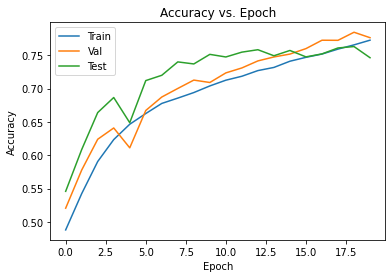

In [18]:
plt.plot(range(len(train_acc_history)), train_acc_history)
plt.plot(range(len(val_acc_history)), val_acc_history)
plt.plot(range(len(test_acc_history)), test_acc_history)
plt.title("Accuracy vs. Epoch")
plt.legend(['Train', 'Val', 'Test'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [14]:
torch.save(model.state_dict(), 'binary_layer_cnn_3.pkl')


In [15]:
from google.colab import files
files.download("binary_layer_cnn_3.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
train_accuracy = 0
for batch_idx, (inputs, labels) in enumerate(train_data_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

   

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)


    # statistics
#     running_loss += loss.item() * inputs.size(0)
#     print("preds", preds)
#     print('labels.data', labels.data)
    train_accuracy += torch.sum(preds == labels.data)
#     break

# epoch_loss = running_loss / len(dataloaders)
train_acc = train_accuracy.double() / len(train_dataset)
print('Training accuracy = ', train_acc )

Training accuracy =  tensor(1.5720, device='cuda:0', dtype=torch.float64)


In [17]:
test_accuracy = 0
for batch_idx, (inputs, labels) in enumerate(test_data_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

  

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)


    # statistics
#     running_loss += loss.item() * inputs.size(0)
    test_accuracy += torch.sum(preds == labels.data)

# epoch_loss = running_loss / len(dataloaders)
test_acc = test_accuracy.double() / len(test_dataset)
print('Test accuracy = ', test_acc )

Test accuracy =  tensor(0.7629, device='cuda:0', dtype=torch.float64)


In [22]:
import pickle as pkl
with open("binary_layer_cnn_3_losses.pkl", 'wb') as f:
  pkl.dump(loss_history, f)

files.download("binary_layer_cnn_3_losses.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
def load_positive_dataset():
    train_dir = 'emotion_recognition/data/train/'
    test_dir = 'emotion_recognition/data/test/'
    categories = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
    positive = ['happy', 'surprise']
    neither = [ 'neutral']
    negative = ['sad', 'fear', 'angry', 'disgust']

    train_file_dictionary = {}
    train_imagefile_to_class_dictionary = {}
    for emotion in categories:
        train_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(positive)):
        for subdir, dirs, files in os.walk(train_dir+positive[i]+'/'):
            for file in files:
                train_file_dictionary[positive[i]].append(train_dir+positive[i]+'/'+file)
                train_imagefile_to_class_dictionary[counter] = {}
                train_imagefile_to_class_dictionary[counter]['file'] = train_dir+positive[i]+'/'+file
                train_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1



    test_file_dictionary = {}
    test_imagefile_to_class_dictionary = {}
    for emotion in categories:
        test_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(positive)):
        for subdir, dirs, files in os.walk(test_dir+positive[i]+'/'):
            for file in files:
                test_file_dictionary[positive[i]].append(test_dir+positive[i]+'/'+file)
                test_imagefile_to_class_dictionary[counter] = {}
                test_imagefile_to_class_dictionary[counter]['file'] = test_dir+positive[i]+'/'+file
                test_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1

    return train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary

In [24]:
def load_negative_dataset():
    train_dir = 'emotion_recognition/data/train/'
    test_dir = 'emotion_recognition/data/test/'
    categories = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
    positive = ['happy', 'surprise']
    neither = [ 'neutral']
    negative = ['sad', 'fear', 'angry', 'disgust']

    train_file_dictionary = {}
    train_imagefile_to_class_dictionary = {}
    for emotion in categories:
        train_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(negative)):
        for subdir, dirs, files in os.walk(train_dir+negative[i]+'/'):
            for file in files:
                train_file_dictionary[negative[i]].append(train_dir+negative[i]+'/'+file)
                train_imagefile_to_class_dictionary[counter] = {}
                train_imagefile_to_class_dictionary[counter]['file'] = train_dir+negative[i]+'/'+file
                train_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1



    test_file_dictionary = {}
    test_imagefile_to_class_dictionary = {}
    for emotion in categories:
        test_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(negative)):
        for subdir, dirs, files in os.walk(test_dir+negative[i]+'/'):
            for file in files:
                test_file_dictionary[negative[i]].append(test_dir+negative[i]+'/'+file)
                test_imagefile_to_class_dictionary[counter] = {}
                test_imagefile_to_class_dictionary[counter]['file'] = test_dir+negative[i]+'/'+file
                test_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1

    return train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary

In [25]:
class PositiveNet(nn.Module):
    def __init__(self):
        super(PositiveNet, self).__init__()
        # torch.Size([256, 1, 64, 64])
        # 3 input image channel (RGB), #6 output channels, 4x4 kernel 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        
        self.drop1 = nn.Dropout(p=0.1)
        self.norm1 = nn.LayerNorm([48, 48])
        self.norm2 = nn.LayerNorm([24, 24])
        
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 96)
        self.fc3 = nn.Linear(96, 2)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.norm1(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = self.norm2(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
#         print(x.shape)

        x = torch.flatten(x, 1)
#         print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc3(x)
        x = F.relu(x)
#         x = self.drop1(x)
        
#         output = x
        output = F.log_softmax(x, dim=1)
        return output
        

In [27]:
train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary = load_positive_dataset()
train_dataset = FacialEmotionDataset(train_imagefile_to_class_dictionary)
train_dataset_augmented = FacialEmotionDataset_Augmented(train_imagefile_to_class_dictionary)

test_dataset = FacialEmotionDataset(test_imagefile_to_class_dictionary)


increased_dataset = torch.utils.data.ConcatDataset([train_dataset_augmented,train_dataset])

print(len(increased_dataset))
train_data_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=32,
                                          shuffle=True,
                                         )
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=True,
                                         )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
positive_model = PositiveNet()
positive_model_ft = positive_model.to(device)
feature_extract = False

params_to_update = positive_model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in positive_model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in positive_model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


criterion = nn.CrossEntropyLoss()
num_epochs = 20

# Train and evaluate
positive_model, positive_val_acc_history, positive_best_model_wts, positive_train_acc_history, positive_test_acc_history, positive_loss_history = train_model(positive_model_ft, increased_dataset, train_data_loader, criterion, optimizer_ft, test_data_loader, test_dataset, num_epochs=num_epochs)

20772
Params to learn:
	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 conv4.weight
	 conv4.bias
	 norm1.weight
	 norm1.bias
	 norm2.weight
	 norm2.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias
	 fc3.weight
	 fc3.bias
Epoch 0/19
----------
train Loss: 21.8635 Acc: 0.6947
val Loss: 19.6291 Acc: 0.6947
Test accuracy =  tensor(0.6810, device='cuda:0', dtype=torch.float64)

Epoch 1/19
----------
train Loss: 18.4109 Acc: 0.7064
val Loss: 16.6048 Acc: 0.7642
Test accuracy =  tensor(0.7881, device='cuda:0', dtype=torch.float64)

Epoch 2/19
----------
train Loss: 15.1262 Acc: 0.7886
val Loss: 14.2742 Acc: 0.8052
Test accuracy =  tensor(0.8407, device='cuda:0', dtype=torch.float64)

Epoch 3/19
----------
train Loss: 12.5499 Acc: 0.8253
val Loss: 11.1046 Acc: 0.8487
Test accuracy =  tensor(0.9033, device='cuda:0', dtype=torch.float64)

Epoch 4/19
----------
train Loss: 11.0702 Acc: 0.8525
val Loss: 9.8972 Acc: 0.8718
Test accuracy =  tensor(0.9090, de

In [28]:
torch.save(positive_model.state_dict(), 'positive_cnn_3.pkl')
files.download("positive_cnn_3.pkl")

with open("positive_cnn_3_val_accuracy.pkl", 'wb') as f:
  pkl.dump(positive_val_acc_history, f)
files.download("positive_cnn_3_val_accuracy.pkl")

with open("positive_cnn_3_train_accuracy.pkl", 'wb') as f:
  pkl.dump(positive_train_acc_history, f)
files.download("positive_cnn_3_train_accuracy.pkl")

with open("positive_cnn_3_test_accuracy.pkl", 'wb') as f:
  pkl.dump(positive_test_acc_history, f)
files.download("positive_cnn_3_test_accuracy.pkl")

with open("positive_cnn_3_losses.pkl", 'wb') as f:
  pkl.dump(positive_loss_history, f)
files.download("positive_cnn_3_losses.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
class NegativeNet(nn.Module):
    def __init__(self):
        super(NegativeNet, self).__init__()
        # torch.Size([256, 1, 64, 64])
        # 3 input image channel (RGB), #6 output channels, 4x4 kernel 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, 
                               padding=1, dilation=1, groups=1, 
                               bias=True, padding_mode='reflect')
        
        
        self.drop1 = nn.Dropout(p=0.1)
        self.norm1 = nn.LayerNorm([48, 48])
        self.norm2 = nn.LayerNorm([24, 24])
        
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 96)
        self.fc3 = nn.Linear(96, 4)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = self.norm1(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = self.norm2(x)
#         print(x.shape)
        
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
#         print(x.shape)

        x = torch.flatten(x, 1)
#         print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop1(x)
        
        x = self.fc3(x)
        x = F.relu(x)
#         x = self.drop1(x)
        
#         output = x
        output = F.log_softmax(x, dim=1)
        return output
        

In [32]:
train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary = load_negative_dataset()
train_dataset = FacialEmotionDataset(train_imagefile_to_class_dictionary)
train_dataset_augmented = FacialEmotionDataset_Augmented(train_imagefile_to_class_dictionary)

test_dataset = FacialEmotionDataset(test_imagefile_to_class_dictionary)


increased_dataset = torch.utils.data.ConcatDataset([train_dataset_augmented,train_dataset])

print(len(increased_dataset))
train_data_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=32,
                                          shuffle=True,
                                         )
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=True,
                                         )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
negative_model = NegativeNet()
negative_model_ft = negative_model.to(device)
feature_extract = False

params_to_update = negative_model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in negative_model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in negative_model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


criterion = nn.CrossEntropyLoss()
num_epochs = 100

# Train and evaluate
negative_model, negative_val_acc_history, negative_best_model_wts, negative_train_acc_history, negative_test_acc_history, negative_loss_history = train_model(negative_model_ft, increased_dataset, train_data_loader, criterion, optimizer_ft, test_data_loader, test_dataset, num_epochs=num_epochs)

26716
Params to learn:
	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 conv4.weight
	 conv4.bias
	 norm1.weight
	 norm1.bias
	 norm2.weight
	 norm2.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias
	 fc3.weight
	 fc3.bias
Epoch 0/99
----------
train Loss: 39.8064 Acc: 0.3492
val Loss: 38.1993 Acc: 0.3705
Test accuracy =  tensor(0.3892, device='cuda:0', dtype=torch.float64)

Epoch 1/99
----------
train Loss: 38.0449 Acc: 0.3917
val Loss: 37.5585 Acc: 0.4182
Test accuracy =  tensor(0.4320, device='cuda:0', dtype=torch.float64)

Epoch 2/99
----------
train Loss: 37.6509 Acc: 0.4103
val Loss: 37.3977 Acc: 0.4236
Test accuracy =  tensor(0.4383, device='cuda:0', dtype=torch.float64)

Epoch 3/99
----------
train Loss: 37.3058 Acc: 0.4226
val Loss: 36.8883 Acc: 0.4372
Test accuracy =  tensor(0.4479, device='cuda:0', dtype=torch.float64)

Epoch 4/99
----------
train Loss: 36.8148 Acc: 0.4438
val Loss: 36.2684 Acc: 0.4601
Test accuracy =  tensor(0.4763, d

In [34]:
torch.save(negative_model.state_dict(), 'negative_cnn_4.pkl')
files.download("negative_cnn_4.pkl")

with open("negative_cnn_4_val_accuracy.pkl", 'wb') as f:
  pkl.dump(negative_val_acc_history, f)
files.download("negative_cnn_4_val_accuracy.pkl")

with open("negative_cnn_4_train_accuracy.pkl", 'wb') as f:
  pkl.dump(negative_train_acc_history, f)
files.download("negative_cnn_4_train_accuracy.pkl")

with open("negative_cnn_4_test_accuracy.pkl", 'wb') as f:
  pkl.dump(negative_test_acc_history, f)
files.download("negative_cnn_4_test_accuracy.pkl")

with open("negative_cnn_4_losses.pkl", 'wb') as f:
  pkl.dump(negative_loss_history, f)
files.download("negative_cnn_4_losses.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
def load_dataset_orig():
    train_dir = 'emotion_recognition/data/train/'
    test_dir = 'emotion_recognition/data/test/'
    categories = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
    positive = ['happy', 'surprise']
    neither = [ 'neutral']
    negative = ['sad', 'fear', 'angry', 'disgust']

    train_file_dictionary = {}
    train_imagefile_to_class_dictionary = {}
    for emotion in categories:
        train_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(categories)):
        for subdir, dirs, files in os.walk(train_dir+categories[i]+'/'):
            for file in files:
                train_file_dictionary[categories[i]].append(train_dir+categories[i]+'/'+file)
                train_imagefile_to_class_dictionary[counter] = {}
                train_imagefile_to_class_dictionary[counter]['file'] = train_dir+categories[i]+'/'+file
                train_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1



    test_file_dictionary = {}
    test_imagefile_to_class_dictionary = {}
    for emotion in categories:
        test_file_dictionary[emotion] = []

    counter = 0
    for i in range(len(categories)):
        for subdir, dirs, files in os.walk(test_dir+categories[i]+'/'):
            for file in files:
                test_file_dictionary[categories[i]].append(test_dir+categories[i]+'/'+file)
                test_imagefile_to_class_dictionary[counter] = {}
                test_imagefile_to_class_dictionary[counter]['file'] = test_dir+categories[i]+'/'+file
                test_imagefile_to_class_dictionary[counter]['label'] = i
                counter += 1

    return train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary

In [43]:
train_imagefile_to_class_dictionary, test_imagefile_to_class_dictionary = load_dataset_orig()

train_dataset_final = FacialEmotionDataset(train_imagefile_to_class_dictionary)

test_dataset_final = FacialEmotionDataset(test_imagefile_to_class_dictionary)



train_data_loader_final = torch.utils.data.DataLoader(train_dataset_final, batch_size=1,
                                          shuffle=True,
                                         )
test_data_loader_final = torch.utils.data.DataLoader(test_dataset_final, batch_size=1,
                                          shuffle=True,
                                         )

In [54]:
test_accuracy = 0.0
for batch_idx, (inputs, labels) in enumerate(test_data_loader_final):
    inputs = inputs.to(device)
    labels = labels.to(device)

  

    outputs = model(inputs)
    
    

    _, preds = torch.max(outputs, 1)

    if preds[0] == 1:
      final_preds = [4]

    if preds[0] == 0:
      pos_outputs = positive_model(inputs)
      _, pos_preds = torch.max(pos_outputs, 1)
      if pos_preds[0] == 0:
        final_preds = [0]
      else:
        final_preds = [3]

    if preds[0] == 2:
      neg_outputs = negative_model(inputs)
      _, neg_preds = torch.max(neg_outputs, 1)
      if neg_preds[0] == 0:
        final_preds = [1]
      elif neg_preds[0] == 1:
        final_preds = [2]
      elif neg_preds[0] == 2:
        final_preds = [5]
      else:
        final_preds = [6]

    # statistics
#     running_loss += loss.item() * inputs.size(0)
    # test_accuracy += np.sum(final_preds == labels.data)
    if int(final_preds[0]) == int(labels.data[0]):
      test_accuracy += 1
      # print(labels, final_preds)

# epoch_loss = running_loss / len(dataloaders)
test_acc = test_accuracy / len(test_dataset_final)
print('Test accuracy = ', test_acc )

Test accuracy =  0.6157704095848425
